<a href="https://colab.research.google.com/github/sprksh-crypto/MachineLearningProjects/blob/main/joinedForSquirrels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

#for authorisation
drive.mount('/content/drive')

#Drive files in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 bird_birdfeeder_random
 BirdfeederModel
'Copy of 4131.jpg'
'Copy of hw3_dataset.tfrecord'
'Essay Drafts'
 hw3_dataset.tfrecord
'joinedForSquirrels MLHW3'
'MLHW 3'
 MLHW3.2
 MLHW3.3
'ML Lab 1'
'ML Lab 2'
'ML Lab 3'
'Physics Project'
'Physics Scripts'
 Pics
'pictures of squirrels at birdfeeders - Google Searc'
 squirrel_birdfeeder_random
 squirrel.jpg
 squirrelsGone
 yolov3.cfg
 yolov3.weights


In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

path='/content/drive/My Drive/squirrel_birdfeeder_random/'
listFileNames=os.listdir(path)

In [ ]:
listFileNames

In [ ]:
#Subselect for squirrels using the same method.

def subSelectImages_SquirrelBirdfeeder(fileList):

  import tensorflow as tf
  import matplotlib.pyplot as plt
  import tensorflow_hub as tfhub
  import numpy as np
  from PIL import Image

  output_5_SquirrelBirdfeeder_filename= []

  model_birdfeeder=tf.keras.models.load_model('/content/drive/My Drive/BirdfeederModel')

  model_coco = tfhub.load('https://tfhub.dev/google/HRNet/coco-hrnetv2-w48/1')

  folderpath= '/content/drive/My Drive/squirrel_birdfeeder_random/'

  #I want it to choose at random:
  file_length=len(fileList)
  useSquirrels_Birdfeeder=np.array(fileList)[np.random.permutation(file_length)[0:file_length]]

  for imgName in useSquirrels_Birdfeeder:
#    image_path= imgName
    image_path = folderpath + imgName
    with tf.io.gfile.GFile(image_path, 'rb') as file:
      image_data = file.read()
    image_format = Image.open(image_path).format

    if image_format.lower() in ('jpeg', 'png', 'gif', 'bmp'):
      inIm=tf.io.decode_jpeg(tf.io.read_file(image_path),channels=3)
      resized_image = tf.image.resize(inIm, [299, 299])
      batched_image = tf.expand_dims(resized_image, axis=0)
      resp_birdfeeder=model_birdfeeder.predict([tf.cast(batched_image,tf.float32)/255.])

      prob_birdfeeder=resp_birdfeeder[0,1]
      #[0,1] is the same as [0][1]

      resp_squirrel=model_coco.predict([tf.cast(resized_image,tf.float32)/255.])
      myIm=resp_squirrel.numpy()

      test=myIm[:,:,:,18].max()

      if test>.7 and prob_birdfeeder > .7:
        output_5_SquirrelBirdfeeder_filename.append(imgName)

        if len(output_5_SquirrelBirdfeeder_filename) == 5:
          break

  return output_5_SquirrelBirdfeeder_filename

In [ ]:
output_SquirrelsAtFeeder=subSelectImages_SquirrelBirdfeeder(listFileNames)

1/1 [==============================] - 1s 899ms/step


In [ ]:
output_SquirrelsAtFeeder

['Squirrels.jpg',
 'squirrel-bird-feeder-indianapolis.jpg',
 'squirrel-in-feeder.jpg',
 'how-to-keep-squirrels-out-of-bird-feeder.jpg',
 'squirrel-7984541_1280.jpg']

In [ ]:
def segmentImages_Squirrel(fileList):

  import tensorflow as tf
  import tensorflow_hub as tfhub
  import numpy as np
  from PIL import Image
  import cv2

  masks=[]

  model_coco = tfhub.load('https://tfhub.dev/google/HRNet/coco-hrnetv2-w48/1')

  #It is specified in the original problem to create masks of a standard size, but that was when both masks were used for the same image.
  #I had resized the masks to all be the same size across different pictures, but remembering what successful outputs from class,
  #I don't think I'm supposed to be doing that. So, I won't.

  for sqrl in fileList:

#    image_path=sqrl

    image_path = '/content/drive/My Drive/squirrel_birdfeeder_random/' + sqrl

    inSquirrelIm=tf.io.decode_jpeg(tf.io.read_file(image_path),channels=3)

    resp_squirrel=model_coco.predict([tf.cast(inSquirrelIm,tf.float32)/255.])
    mySquirrelIm=resp_squirrel.numpy()

    test=mySquirrelIm[:,:,:,18].max()

    if test>.7:

      maskIm_squirrel=np.ones_like(inSquirrelIm)
      mask_squirrel=tf.squeeze(resp_squirrel)[:,:,18]>.4

      if len(inSquirrelIm[mask_squirrel])>0:
        maskIm_squirrel=inSquirrelIm[mask_squirrel].numpy().max()*maskIm_squirrel

      maskIm_squirrel[mask_squirrel]=inSquirrelIm[mask_squirrel]

      mask_image = Image.fromarray(maskIm_squirrel)

#      maskIm_squirrel1 = cv2.cvtColor(maskIm_squirrel, cv2.COLOR_BGR2GRAY)

      masks.append(mask_image)

  return masks

In [ ]:
squirrelMask=segmentImages_Squirrel(output_SquirrelsAtFeeder)

In [ ]:
import cv2

for img in squirrelMask:
  print(cv2.imread(img).shape)

TypeError: ignored

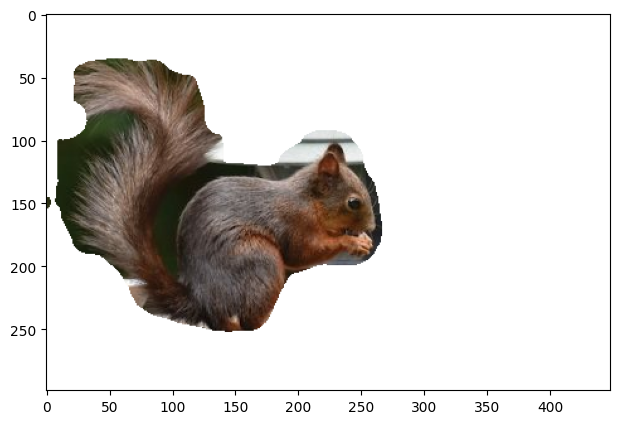

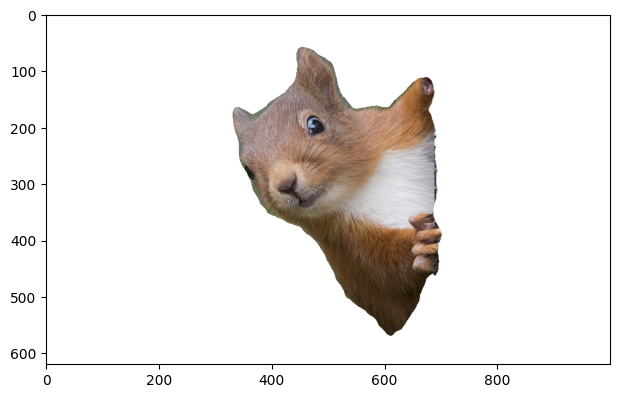

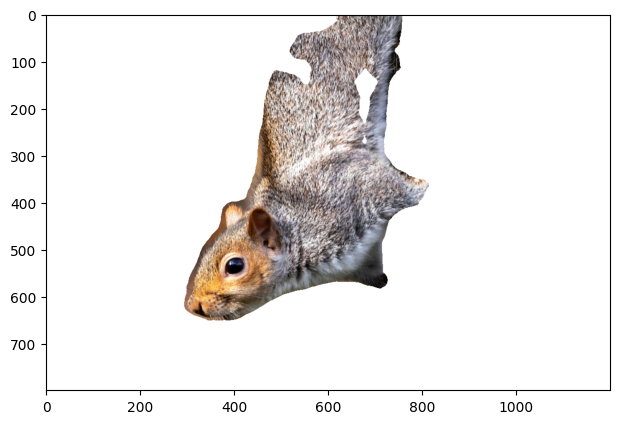

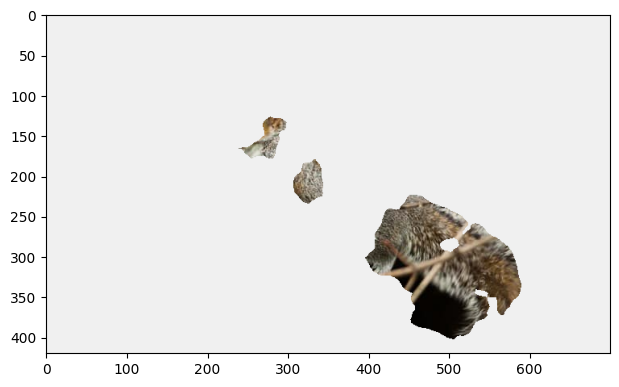

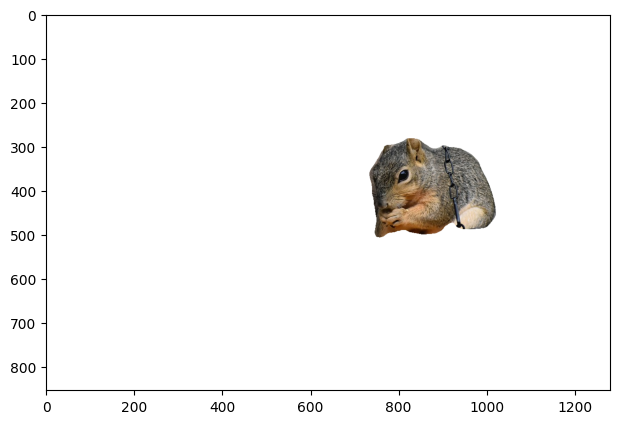

In [ ]:
import matplotlib.pyplot as plt

for img in squirrelMask:
  plt.figure(figsize=(16,32))
  plt.subplot(1,2,2)
  plt.imshow(img)

In [ ]:
def removeSquirrel1(fileList,squirrelMasks):

  import tensorflow as tf
  import cv2
  import numpy as np

  filenames_without_ext=[]

  #First I need to read in all of the original images:

  for i, fl in enumerate(fileList):

    image_path = '/content/drive/My Drive/squirrel_birdfeeder_random/' + fl

    inSquirrelIm=cv2.imread(image_path)

#    print(inSquirrelIm.shape, inSquirrelIm.dtype)
#    print(squirrelMask[i].shape, squirrelMask[i].dtype)

#    name_without_ext= fl.split('.')[0]

#    mask= cv2.imread(squirrelMasks[i])
#    print(squirrelMasks)

#    if mask.shape[-1] != inSquirrelIm.shape[-1]:
#      mask= np.expand_dims(mask, axis=-1)

#    _, thresholded_mask = cv2.threshold(squirrelMask[i], 1, 255, cv2.THRESH_BINARY)

    mask_image = squirrelMask[i].convert('L')  # Convert to grayscale
    mask_image = mask_image.point(lambda x: 255 if x > 0 else 0, '1')


#    for sqMsk in squirrelMask:
#      print(sqMsk.shape, sqMsk.dtype)
    dst = cv2.inpaint(inSquirrelIm, mask_image, 3, cv2.INPAINT_NS)
    cv2.imwrite('/content/drive/My Drive/squirrelsGone/'+name_without_ext+'-squirrelsRemoved.jpg', dst)


#    sqMask=cv2.imread(sqMsk)
#    squirrelMasks = sqMsk.np()
#    squirrelMasks1= np.uint8(*255)

#    print(sqMsk.shape, sqMsk.dtype)




  #Then I need to load the squirrel Masks.

In [ ]:
removeSquirrel1(output_SquirrelsAtFeeder,squirrelMask)

error: ignored

In [ ]:
def removeSquirrel(fileList,squirrelMasks):

  import tensorflow as tf

  filenames_without_ext=[]

  #First I need to read in all of the original images:

  for fl in fileList:
    image_path = '/content/drive/My Drive/squirrel_birdfeeder_random/' + fl

    inSquirrelIm=tf.io.decode_jpeg(tf.io.read_file(image_path),channels=3)

    name_without_ext= fl.split('.')[0]
    filenames_without_ext.append(name_without_ext)

#    print(inSquirrelIm.shape, inSquirrelIm.dtype)

  #Then I need to load the squirrel masks.

  for sqMsk in squirrelMask:
    squirrelMasks = tf.convert_to_tensor(sqMsk)
    print(squirrelMasks.shape, squirrelMasks.dtype)


In [ ]:
def removeSquirrel(fiveJPEGfilenames, squirrelMasks):

  import cv2
  import numpy as np
  import tensorflow as tf
  import os
  import PIL
  import torch
  from diffusers import StableDiffusionInpaintPipeline

  #here are the assumptions I've made: a file name is not a file path. In subSelect I've taken a folder path as the argument, but it outputs filenames for 5 selected images.
  #But still I need the folder path to join them to retrieve the image data. So I'm making it an additional argument of the function.

  resizing=(299,299)

  pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
  pipeline = pipeline.to("cuda")

  for fname in fiveJPEGfilenames:
    imagePath= '/content/drive/My Drive/squirrel_birdfeeder_random/' + fname
    image=cv2.imread(imagePath)

    resized_image = cv2.resize(image, resizing)

    preImpaintedImage = resized_image.copy()

    for mask in squirrelMasks:
      maskedIm= PIL.Image.fromarray((mask * 255).astype(np.uint8))
      maskedIm1 = PIL.Image.composite(image, PIL.Image.new('RGB', image.size), maskedIm)

      tensor_image = torch.tensor(np.array(maskedIm1)).permute(2, 0, 1).unsqueeze(0).to("cuda").float() / 255.0

      with torch.no_grad():
        inpainted_image = pipeline(tensor_image)

      inpainted_image = PIL.Image.fromarray((inpainted_image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

      orgFilename, extension = os.path.splitext(fname)
      newFilename= f"{orgFilename}-squirrelsRemoved{extension}"
      cv2.imwrite(newFilename, inpainted_image)

In [ ]:
removeSquirrel(output_SquirrelsAtFeeder,squirrelMask)

ImportError: ignored

In [ ]:
def removeSquirrel(fiveJPEGfilenames, squirrelMasks):

  import cv2
  import numpy as np
  import tensorflow as tf
  import os

  #here are the assumptions I've made: a file name is not a file path. In subSelect I've taken a folder path as the argument, but it outputs filenames for 5 selected images.
  #But still I need the folder path to join them to retrieve the image data. So I'm making it an additional argument of the function.

  resizing=(299,299)

  for fname in fiveJPEGfilenames:
    imagePath= '/content/drive/My Drive/squirrel_birdfeeder_random/' + fname
    image=cv2.imread(imagePath)

    resized_image = cv2.resize(image, resizing)

    preImpaintedImage = resized_image

    for mask in squirrelMasks:

      mask0= (mask * 255)

      mask1 = np.uint8(mask)

      inpaintedImage=cv2.inpaint(preImpaintedImage, np.array(mask), 3, cv2.INPAINT_TELEA)

      orgFilename, extension = os.path.splitext(fname)
      newFilename= f"{orgFilename}-squirrelsRemoved{extension}"
      cv2.imwrite(newFilename, inpaintedImage)

In [ ]:
!pip install --upgrade pip

!pip install diffusers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch

In [ ]:
from diffusers import StableDiffusionInpaintPipeline

In [ ]:
pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting",torch_dtype=torch.float32).to("cpu")

safety_checker/model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
def download_image(url):
  response = requests.get(url)
  return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))
#prompt = "Face of a yellow cat, high resolution, sitting on a park bench"
#prompt = 'Face of a happy boy toddler, high resolution, sitting on a park bench'
prompt = 'A pileated woodpecker, high resolution, sitting on a park bench'
image = pipeline(prompt=prompt, imag

In [ ]:
from io import BytesIO

In [ ]:
def removeSquirrel(fileList, squirrelMasks):

  from PIL import Image
  import matplotlib.pyplot as plt

  for i in range(len(fileList)):
      image_path = '/content/drive/My Drive/squirrel_birdfeeder_random/'+ fileList[i]
      original_image = Image.open(image_path).resize((512, 512))
      masked_image = Image.open(squirrelMasks[i]).resize((512, 512))
      prompt = 'Grass field, high resolution'
      inpainted_image = pipeline(prompt=prompt, image=original_image, mask_image=masked_image).images[0]

      plt.imshow(inpainted_image)

In [ ]:
removeSquirrel(output_SquirrelsAtFeeder,squirrelMask)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│ in removeSquirrel:9                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/PIL/Image.py:2984 in open                                │
│                                                                                                  │
│   2981 │   │   fp = io.BytesIO(fp.read())                                                        │
│   2982 │   │   exclusive_fp = True                                                               │
│   2983 │                                                                                         │
│ ❱ 2984 │   prefix = fp.read(16)                                                                  │
│   2985 │                                                                                         │
│   2986 │   preinit()                                                                             │
│   2987                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/PIL/Image.py:546 in __getattr__                          │
│                                                                                                  │
│    543 │   │   │   │   stacklevel=2,                                                             │
│    544 │   │   │   )                                                                             │
│    545 │   │   │   return self._category                                                         │
│ ❱  546 │   │   raise AttributeError(name)                                                        │
│    547 │                                                                                         │
│    548 │   @property                                                                             │
│    549 │   def width(self):                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: read